# Predicting NBA Players' Salary Through Deep Learning Model

#### Weon Gyu Jeon

## 1. Introduction

I have previously built simple models using [Linear Regression](https://www.kaggle.com/code/ratin21/predicting-nba-salary-through-linear-regression) and [Random Forest](https://www.kaggle.com/code/ratin21/predicting-nba-salary-through-random-forest). This time, I am going to use **Pytorch** to build deep learning model to predict NBA player's salary for next season. To train the deep learning model, I used 15 years of player stats and salary data (2010-2025).

## 2. Preparation

### 2.1 Packages & Libraries

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

### 2.2 Data Preparation

Full Scrapping Script for 15 years of player stats and salaries can be found on my [Github Repository](https://github.com/edwinjeon/NBA-Salary-Prediction).

In [11]:
df = pd.read_csv('NBA Player Stats and Salaries_2010-2025.csv')

#### 2.2.1 Data Component

In [13]:
pd.set_option('display.max_columns', None)
df.head(1)

,Player,Salary,Year,Pos,Age,Team,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Kobe Bryant,23034375,2010,SG,31,LAL,73,73,38.8,9.8,21.5,0.456,1.4,4.1,0.329,8.5,17.4,0.487,0.488,6.0,7.4,0.811,1.1,4.3,5.4,5.0,1.5,0.3,3.2,2.6,27.0


## 3. Correlation

Let's see correlation of each stat to salary.

In [16]:
numeric_df = df.select_dtypes(include='number')
correlations = numeric_df.corr()['Salary'].drop('Salary').sort_values(ascending=False)

Corrleations:
```
PTS: 0.657     FG: 0.647     FGA: 0.626     FT: 0.583
2P: 0.574      FTA: 0.572    MP: 0.556      TOV: 0.549
2PA: 0.549     DRB: 0.525    AST: 0.519     GS: 0.504
TRB: 0.463     3PA: 0.449    3P: 0.446      STL: 0.414
PF: 0.333      Age: 0.285    G: 0.264       BLK: 0.263
Year: 0.233    ORB: 0.233    FT%: 0.186     eFG%: 0.183
FG%: 0.156     2P%: 0.141    3P%: 0.115
```

### 3.1 Barplot

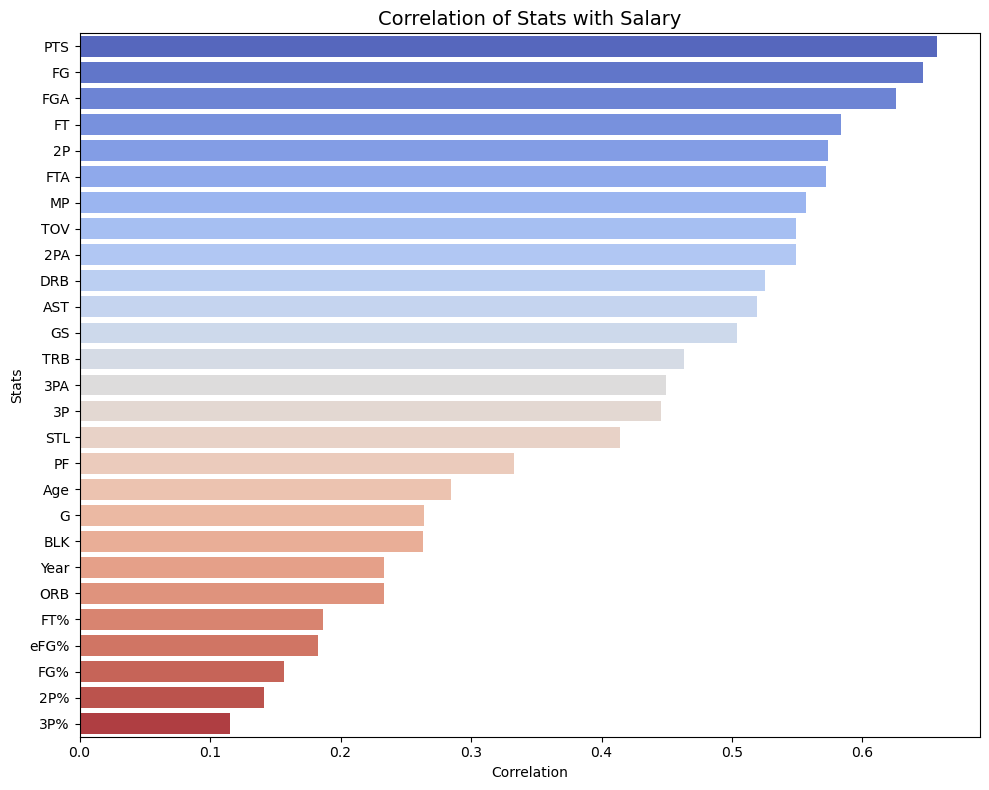

In [19]:
plt.figure(figsize=(10, 8))
sns.barplot(
    x=correlations.values,
    y=correlations.index,
    hue=correlations.index,
    palette="coolwarm",
    legend=False
)
plt.title("Correlation of Stats with Salary", fontsize=14)
plt.xlabel("Correlation")
plt.ylabel("Stats")
plt.tight_layout()
plt.show()

## 4. Building Model

### 4.1 Feature selection
We're building a deep learning model, and neural network is not necessarily sensitive to multicollinearity. So I put all the independent variables into consideration.

In [22]:
features = ['PTS', 'FG', 'FGA', 'FT', '2P', 'FTA', 'MP', 'TOV', '2PA', 'DRB', 'AST', 'GS', 'TRB', '3PA', '3P', 'STL', 'Age']

Scaling salary to millions $ for convenience

In [24]:
df['Salary_scaled'] = df['Salary'] / 1_000_000

### 4.2 Preparation for training

Extract features and target variable

In [27]:
X = df[features].values
y = df['Salary_scaled'].values.reshape(-1, 1)

Split into train, validation, and test sets: 72.25% train set, 15% test set, 12.25% validation set 

In [29]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42
)

Scale features using StandardScaler

In [31]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Convert to PyTorch tensors

In [33]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

Create datasets and dataloaders: batch size set to default

In [35]:
batch_size = 64
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

### 4.3 Defining the model

Two hidden layers with ReLU activation and Dropout for regularization, <br>
hidden layer 1: 64 units + ReLU + 20% dropout, hidden layer 2: 32 units + ReLU + 10% dropout <br>
output layer with a single layer to predict salary

In [38]:
class SalaryPredictor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

In [39]:
model = SalaryPredictor(len(features))

### 4.4 Training

#### 4.4.1 Setup

MSE as a loss function, Adam optimizer with a learning rate of 0.001.

In [43]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trained up for 50 epochs, early stopping patience of 5.

In [45]:
epochs = 50
early_stop_patience = 5

initialization: best validation loss to infinity.

In [47]:
best_val_loss = np.inf
early_stop_counter = 0

#### 4.4.2 Loop

In [ ]:
# Training loop (epochs)
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_losses.append(loss.item())
    val_loss = np.mean(val_losses)

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered!")
            break

Epoch 1 - Train Loss: 75.9504 - Val Loss: 41.5020
Epoch 2 - Train Loss: 37.3990 - Val Loss: 32.6878
Epoch 3 - Train Loss: 33.4833 - Val Loss: 30.7502
Epoch 4 - Train Loss: 32.6555 - Val Loss: 30.0233
Epoch 5 - Train Loss: 31.9050 - Val Loss: 30.7442
Epoch 6 - Train Loss: 31.6806 - Val Loss: 29.2812
Epoch 7 - Train Loss: 30.8488 - Val Loss: 28.9413
Epoch 8 - Train Loss: 31.4318 - Val Loss: 28.8191
Epoch 9 - Train Loss: 31.4620 - Val Loss: 29.0455
Epoch 10 - Train Loss: 31.2186 - Val Loss: 28.3501
Epoch 11 - Train Loss: 30.7433 - Val Loss: 28.1807
Epoch 12 - Train Loss: 30.1662 - Val Loss: 28.0728
Epoch 13 - Train Loss: 30.1366 - Val Loss: 27.3291
Epoch 14 - Train Loss: 30.0275 - Val Loss: 27.0457
Epoch 15 - Train Loss: 29.5742 - Val Loss: 26.9718
Epoch 16 - Train Loss: 28.9456 - Val Loss: 26.5075
Epoch 17 - Train Loss: 29.2607 - Val Loss: 26.3125
Epoch 18 - Train Loss: 28.7773 - Val Loss: 26.3491
Epoch 19 - Train Loss: 28.6480 - Val Loss: 26.3853
Epoch 20 - Train Loss: 28.8714 - Val Los

### 4.5 Model to use

Load the best model

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

Running inference on test set

In [ ]:
all_preds = []
all_targets = []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

Concatenate all batch results into full test sets

In [ ]:
y_pred = np.concatenate(all_preds).reshape(-1)
y_test_orig = np.concatenate(all_targets).reshape(-1)

Rescale salary to original scale, millions

In [ ]:
y_pred_unscaled = y_pred * 1_000_000
y_test_unscaled = y_test_orig * 1_000_000

### 4.6 Evaluation

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
r2 = r2_score(y_test_unscaled, y_pred_unscaled)

print(f"Test RMSE: ${rmse:,.2f}")
print(f"Test R² Score: {r2:.4f}")

MAE and R^2 scores are not bad, especially compared for results I saw from Linear Regression and Random Forest. There are still room for improvement.

## 5. Prediction

### 5.1 Prediction Function

In [ ]:
def predict_salary(player_name, model, scaler, features, df):
    player_rows = df[df['Player'] == player_name]

    if player_rows.empty:
        print(f"Player '{player_name}' not found in the dataset.")
        return

    # Select the most recent season's stats
    player_row = player_rows[player_rows['Year'] == player_rows['Year'].max()].iloc[0]

    # Prepare feature vector as a DataFrame with a single row
    player_features = pd.DataFrame([player_row[features]])

    scaled_features = scaler.transform(player_features.values)

    input_tensor = torch.tensor(scaled_features, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        predicted_scaled = model(input_tensor).item()

    predicted_salary = predicted_scaled * 1_000_000
    actual_salary = player_row['Salary']

    print(f"Predicted 2025–26 season salary for {player_name}: ${predicted_salary:,.2f}")
    print(f"Actual {player_row['Year']} salary: ${actual_salary:,.2f}")

### 5.2 Predicting with actual players

As the model is predicting new salary for next year, let's try some players who have contracts expiring next year. 
<br>Let's first try with **James Harden**, who has player option for next season. His stats: 22.8 PTS, 8.7 AST, 5.8 REB, 0.7 BLK, 1.5 STL at age of 35.

In [ ]:
predict_salary("James Harden", model, scaler, features, df)

**Lebron James** also has his player option for next season. His stats: 24.4 PTS, 8.2 AST, 7.8 REB, 0.6 BLK, 1 STL at the age of 40.

In [ ]:
predict_salary("LeBron James", model, scaler, features, df)

Lastly, **Ty Jerome**, one of the best bench players this season, also gets Free Agent option this season. <br>
His stats: 12.5 PTS, 3.4 AST, 2.5 REB, 0 BLK, 1.1 STL at the age of 27.

In [ ]:
predict_salary("Ty Jerome", model, scaler, features, df)